<a href="https://colab.research.google.com/github/Malavika-Gupta/Kepler-Exoplanet-Detection/blob/main/Kepler_Exoplanet(Project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

In [ ]:
file_path='/content/kepler_dataset.csv'
df=pd.read_csv(file_path,header=0)
#wecan directly use column names with header=0
#7803 data points 39 feature columns
#print few rows of starting default 5
df=df.loc[:6900]

In [ ]:
#first we split then we normalize to prevent data leakage and increase accuracy
l=['ExoplanetCandidate','ExoplanetConfirmed']
X=df.drop(l,axis=1)  # Features (excluding the target column)
y=df['ExoplanetCandidate']  # Target variable
#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/7000, random_state=42)

#Normalizatiom
scaler=StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


In [ ]:
#Building Neural Network Model
model=Sequential()

# Add input layer
model.add(Dense(units=16,activation='sigmoid', input_shape=(X_train_normalized.shape[1],)))

# Add hidden layers
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dense(units=4,activation='sigmoid'))

# Add the output layer
model.add(Dense(units=1,activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                608       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 4)                 36        
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 785 (3.07 KB)
Trainable params: 785 (3.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
74/74 [==============================] - 1s 6ms/step - loss: 0.6881 - accuracy: 0.5421 - val_loss: 0.6748 - val_accuracy: 0.5726
Epoch 2/50
74/74 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5598 - val_loss: 0.6497 - val_accuracy: 0.5980
Epoch 3/50
74/74 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6605 - val_loss: 0.6049 - val_accuracy: 0.7652
Epoch 4/50
74/74 [==============================] - 0s 3ms/step - loss: 0.5747 - accuracy: 0.8300 - val_loss: 0.5365 - val_accuracy: 0.8598
Epoch 5/50
74/74 [==============================] - 0s 3ms/step - loss: 0.5015 - accuracy: 0.8850 - val_loss: 0.4595 - val_accuracy: 0.8953
Epoch 6/50
74/74 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.9167 - val_loss: 0.3861 - val_accuracy: 0.9257
Epoch 7/50
74/74 [==============================] - 0s 3ms/step - loss: 0.3587 - accuracy: 0.9370 - val_loss: 0.3246 - val_accuracy: 0.9476
Epoch 8/50
74/74 [==

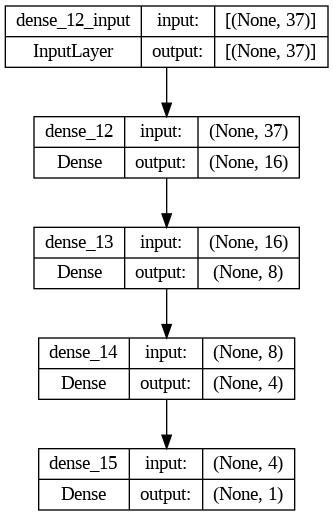

In [ ]:
# Train the model
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

from tensorflow.keras.utils import plot_model

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))
